In [1]:
# Optimization for Machine Learning
# Problem: projected gradient descent for SVM

%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pegasos import *
from cyclic_coordinate_descent import *
from random_coordinate_descent import *
from utils import *


from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
import os, struct
from array import array
from SMO import SMO
from RSMO import RSMO

np.random.seed(1337)

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}
matplotlib.rc('font', **font)


### Load mnist training and validation images. Plot examples from both sets and show their corresponding labels as verification.

In [2]:
# mnist load images
train_imgs_dir = './dataset/mnist/train-images.idx3-ubyte'
train_labels_dir = './dataset/mnist/train-labels.idx1-ubyte'
val_imgs_dir = './dataset/mnist/t10k-images.idx3-ubyte'
val_labels_dir = './dataset/mnist/t10k-labels.idx1-ubyte'
train_imgs, train_labels = mnist_data_loader(train_imgs_dir, train_labels_dir)
print("mnist: number of training examples", train_imgs.shape[0])

val_imgs, val_labels = mnist_data_loader(val_imgs_dir, val_labels_dir)
print("mnist: number of validation examples", val_imgs.shape[0])
HEIGHT = 28
WIDTH = 28

# Reshape images to vectors
train_vectors = train_imgs.reshape(-1, HEIGHT * WIDTH)
val_vectors = val_imgs.reshape(-1, HEIGHT * WIDTH)

mnist: number of training examples 11769
mnist: number of validation examples 1932


## Plot Functions

In [3]:
# initialize w, lambda
num_examples, num_features = train_vectors.shape

def error_plot(w, _lambda, img_vectors, labels, algorithm, dilate=1, yscale='log'):
    """plot errors"""
    error_list = cal_objective_dilate(w, _lambda, img_vectors, labels, dilate)
    print(algorithm+" error:", error_list[-1])
    plt.xlabel('Step')
    plt.ylabel('Error')
#     plt.yscale(yscale)
    num_iters = len(error_list)
    plt.plot(np.linspace(0, num_iters*dilate, num=num_iters), error_list, **kwargs)

def cal_objective_dilate(w, _lambda, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [objective(x, _lambda, img_vectors, labels) \
                                for x in w[0:num_iters:dilate]]

def acc_plot(w, img_vectors, labels, algorithm, dilate=1):
    """plot accuracies"""
    acc_list = cal_acc_dilate(w, img_vectors, labels, dilate)
    print(algorithm+" acc:", acc_list[-1])
    plt.xlabel('Step')
    plt.ylabel('Acc')
    num_iters = len(acc_list)
    plt.plot(np.linspace(0, num_iters*dilate, num=num_iters), acc_list, **kwargs)

def cal_acc_dilate(w, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [compute_accuracy(x, img_vectors, labels) for x in w[0:num_iters:dilate]]

## Training error

In [4]:
def average_weight(w):
    w_sum = np.zeros([num_features,1])
    w_average = []
    for i in range(0,len(w)):
        w_sum += w[i]
        w_average.append(w_sum/(i+1))
    return w_average

def set_pegasos_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 3000
    return _lambda, num_steps, w0

def set_primal_cyclic_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias

def set_primal_random_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias


In [5]:
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors, train_labels, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors, train_labels)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors, train_labels))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors, train_labels))
print("        ")

# SVM using SMO descend
smo_model = SMO(C=1.0)
smo_model.fit(train_vectors, train_labels)
print("        ")

# Random SMO
rsmo_model = RSMO(C=1.0)
rsmo_model.fit(train_vectors, train_labels)

Pegasos training starts...
Iterations: 2999    total_time: 0.7928457260131836
Pegasos training ends...
Pegasos training error   0.09323970737729396
        
CCD training starts...
epoch: 0    total_time: 56.885459899902344
epoch: 1    total_time: 102.87711429595947
epoch: 2    total_time: 148.86938405036926
epoch: 3    total_time: 192.7495665550232
CCD training ends...
CCD training error:   0.11733177803608917
        
RCD training starts...
epoch: 0    total_time: 64.14678525924683
epoch: 1    total_time: 112.47644972801208
epoch: 2    total_time: 159.04408645629883
epoch: 3    total_time: 205.02814316749573
RCD training ends...
RCD training error:   0.11601812380935209
        
SMO training start
SMO training ends....
        
RSMO training start
RSMO training ends....


In [14]:
print("Pegasos total running time:", pegasos_running_time[-1], "     Pegasos total number of iterations:", 3000)
print("CCD total running time:", primal_cyclic_cd_running_time[-1], "      CCD total number of iterations:",4*784)
print("RCD total running time:", primal_random_cd_running_time[-1], "     RCD total number of iterations:",4*784)
print("SMO total running time:", smo_model.time_ls[-1], "     SMO total number of iterations: ", 11769)
print("RSMO total running time:", rsmo_model.time_ls[-1], "     RSMO total number of iterations:",11769)

Pegasos total running time: 0.6940436363220215      Pegasos total number of iterations: 3000
CCD total running time: 192.74956512451172       CCD total number of iterations: 3136
RCD total running time: 205.02814197540283      RCD total number of iterations: 3136
SMO total running time: 340.6470263004303      SMO total number of iterations:  11769
RSMO total running time: 347.64609718322754      RSMO total number of iterations: 11769


Pegasos error: 0.09343446579972894
CCD error: 0.12261214135419388
RCD error: 0.11993381981331788
SMO error: 0.10549316861881218
rSMO error: 0.111781916901183


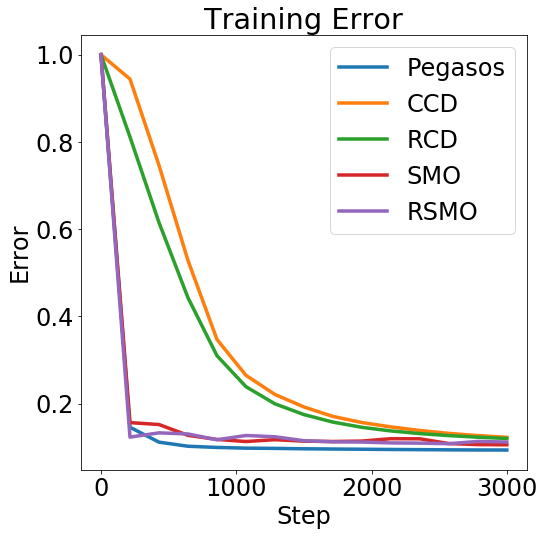

In [6]:
# training error plot
plot_dilation = 200
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors, train_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors, train_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors, train_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors, train_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors, train_labels, 'rSMO', plot_dilation)

plt.title(' Training Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.9841957685444813
CCD acc: 0.975443962953522
RCD acc: 0.9816466989548814
SMO acc: 0.9853003653666412
rSMO acc: 0.9819016059138415


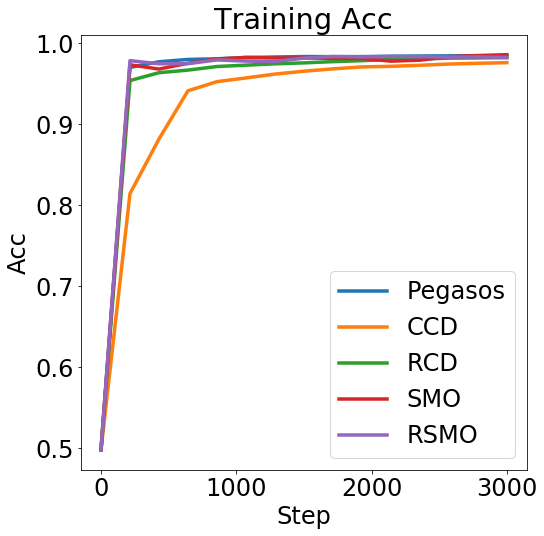

In [7]:
# training acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], train_vectors, train_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors, train_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors, train_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], train_vectors, train_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors, train_labels, 'rSMO', plot_dilation)

plt.title(' Training Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos error: 0.09737174782717348
CCD error: 0.12707889253525456
RCD error: 0.1238965909961261
SMO error: 0.10990184859501663
rSMO error: 0.11417576036439066


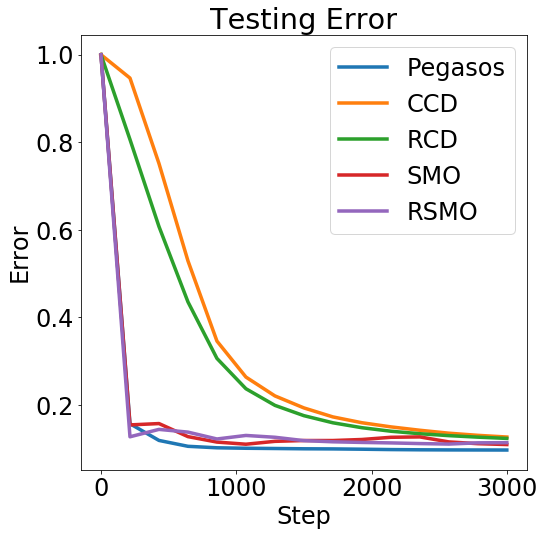

In [8]:
# test error plot
plt.figure(figsize=(8, 8))
error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
plt.title(' Testing Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.9829192546583851
CCD acc: 0.9730848861283644
RCD acc: 0.9818840579710145
SMO acc: 0.984472049689441
rSMO acc: 0.9813664596273292


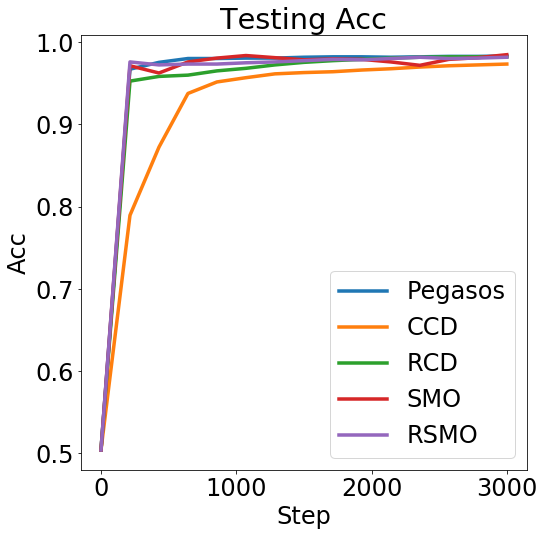

In [9]:
# test acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

plt.title(' Testing Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

# Cifar Tests

In [19]:
# Cifar
folder = 'dataset/cifar/'
train_vectors, train_labels, val_vectors, val_labels, label_names = get_cifar10(folder)
# print(train_vectors.shape, train_labels.shape, val_vectors.shape, val_labels.shape)
num_examples, num_features = train_vectors.shape

(10000, 3072)


In [20]:
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors, train_labels, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors, train_labels)) # print final training error
print("        ")
# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors, train_labels))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors, train_labels))
print("        ")

# SVM using SMO descend
smo_model = SMO(C=1.0)
smo_model.fit(train_vectors, train_labels)

# Random SMO
rsmo_model = RSMO(C=1.0)
rsmo_model.fit(train_vectors, train_labels)

Pegasos training starts...
Iterations: 2999    total_time: 0.6633129119873047
Pegasos training ends...
Pegasos training error   0.45845847948003005
        
CCD training starts...
epoch: 0    total_time: 216.30677151679993
epoch: 1    total_time: 426.0729396343231
epoch: 2    total_time: 627.6095016002655
epoch: 3    total_time: 821.4753665924072
CCD training ends...
CCD training error:   0.49789563098806555
        
RCD training starts...
epoch: 0    total_time: 245.80655908584595
epoch: 1    total_time: 466.97350025177
epoch: 2    total_time: 685.634791135788
epoch: 3    total_time: 906.368950843811
RCD training ends...
RCD training error:   0.49361038398696766
        
SMO training start
SMO training ends....
RSMO training start
RSMO training ends....


In [21]:
print("Pegasos total running time:", pegasos_running_time[-1], "     Pegasos total number of iterations:", 3000)
print("CCD total running time:", primal_cyclic_cd_running_time[-1], "      CCD total number of iterations:",4*784)
print("RCD total running time:", primal_random_cd_running_time[-1], "     RCD total number of iterations:",4*784)
print("SMO total running time:", smo_model.time_ls[-1], "     SMO total number of iterations: ", 10000)
print("RSMO total running time:", rsmo_model.time_ls[-1], "     RSMO total number of iterations:",10000)

Pegasos total running time: 0.6633119583129883      Pegasos total number of iterations: 3000
CCD total running time: 821.4753656387329       CCD total number of iterations: 3136
RCD total running time: 906.3689501285553      RCD total number of iterations: 3136
SMO total running time: 263.83988666534424      SMO total number of iterations:  10000
RSMO total running time: 258.8780333995819      RSMO total number of iterations: 10000


Pegasos error: 0.4625961974600917
CCD error: 0.6859248339454936
RCD error: 0.6326504511273205
SMO error: 0.5094937630640934
rSMO error: 0.5321558261104926


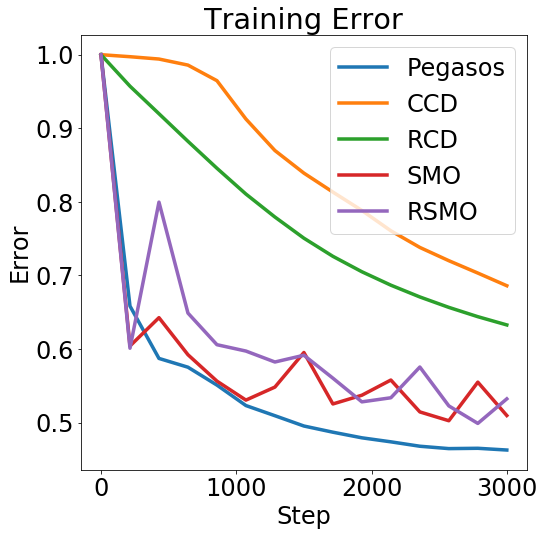

In [22]:
# training error plot
plot_dilation = 200
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors, train_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors, train_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors, train_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors, train_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors, train_labels, 'rSMO', plot_dilation)

plt.title(' Training Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.8189
CCD acc: 0.7409
RCD acc: 0.763
SMO acc: 0.8223
rSMO acc: 0.8178


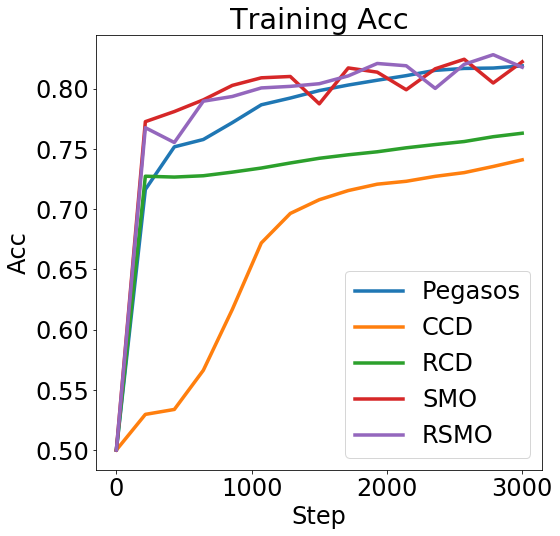

In [23]:
# training acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], train_vectors, train_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors, train_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors, train_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], train_vectors, train_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors, train_labels, 'rSMO', plot_dilation)

plt.title(' Training Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos error: 0.48035504565284587
CCD error: 0.6921447409823775
RCD error: 0.6442502516911577
SMO error: 0.5274989917980343
rSMO error: 0.550613327534698


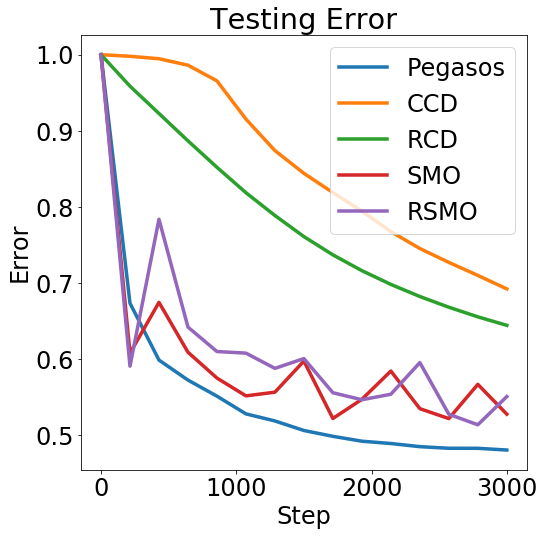

In [24]:
# test error plot
plt.figure(figsize=(8, 8))
error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
plt.title(' Testing Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.8025
CCD acc: 0.7395
RCD acc: 0.7645
SMO acc: 0.8155
rSMO acc: 0.8085


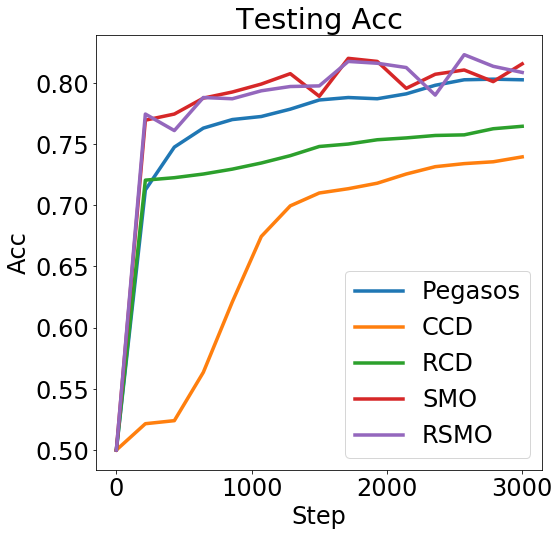

In [25]:
# test acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

plt.title(' Testing Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])